In [1]:
# ========================================
# 完整的 TransNAS 架构层级分析工具
# ========================================

# ========== 第 1 部分：导入库和初始化路径 ==========
import sys
from pathlib import Path
import importlib.util
import numpy as np
import torch
import torch.nn as nn
import argparse
import itertools
import matplotlib.pyplot as plt

# 设置路径
CURRENT_DIR = Path().resolve()
ROOT_DIR = CURRENT_DIR.parent
NASLIB_ROOT = ROOT_DIR / "NASLib"
sys.path.insert(0, str(NASLIB_ROOT))

print("=" * 80)
print("TransNAS 架构层级分析工具")
print("=" * 80)
print(f"NASLib 路径: {NASLIB_ROOT}\n")


# ========== 第 2 部分：动态加载 TransNAS API ==========
def load_transbench_api():
    """加载 TransNAS-Bench-101 API"""
    api_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "api.py"
    spec = importlib.util.spec_from_file_location("transbench_api", api_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.TransNASBenchAPI

def load_transbench_classes():
    """加载 TransNAS-Bench-101 搜索空间类"""
    graph_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "graph.py"
    spec = importlib.util.spec_from_file_location("transbench_graph", graph_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.TransBench101SearchSpaceMicro, module.TransBench101SearchSpaceMacro, module


# ========== 第 3 部分：查找指定排名的架构 ==========
def find_architecture_by_rank(api, search_space, task, rank, from_top=True):
    """
    根据排名查找架构
    
    Args:
        api: TransNASBenchAPI 实例
        search_space: "micro" 或 "macro"
        task: 任务名称
        rank: 排名（从 1 开始）
        from_top: True 表示从最好开始（第1名是最好），False 表示从最差开始（第1名是最差）
    
    Returns:
        arch_str: 架构字符串
        gt_score: GT 分数
        metric_name: 使用的指标名称
    """
    # 确定 GT 指标
    if task in ["class_scene", "class_object", "jigsaw"]:
        metric_name = "valid_top1"
    elif task == "room_layout":
        metric_name = "valid_neg_loss"
    elif task == "segmentsemantic":
        metric_name = "valid_acc"
    else:  # autoencoder, normal
        metric_name = "valid_ssim"
    
    print(f"正在查找 {search_space} / {task} 的架构...")
    print(f"GT 指标: {metric_name}")
    
    # 收集所有架构的 GT 分数
    all_archs = api.all_arch_dict[search_space]
    arch_scores = []
    
    for arch_str in all_archs:
        try:
            gt_score = api.get_single_metric(arch_str, task, metric_name, mode="final")
            arch_scores.append((arch_str, gt_score))
        except:
            continue
    
    # 排序
    arch_scores_sorted = sorted(arch_scores, key=lambda x: x[1], reverse=True)
    
    # 选择指定排名
    if from_top:
        selected = arch_scores_sorted[rank - 1]
        print(f"✓ 找到第 {rank} 名架构（共 {len(arch_scores_sorted)} 个）")
    else:
        selected = arch_scores_sorted[-(rank)]
        print(f"✓ 找到倒数第 {rank} 名架构（共 {len(arch_scores_sorted)} 个）")
    
    return selected[0], selected[1], metric_name


# ========== 第 4 部分：创建模型 ==========
def create_model_from_arch_str(arch_str, search_space, task, device):
    """从架构字符串创建模型"""
    TransBench101SearchSpaceMicro, TransBench101SearchSpaceMacro, _ = load_transbench_classes()
    
    # 创建搜索空间
    if search_space == "micro":
        if task == "segmentsemantic":
            ss = TransBench101SearchSpaceMicro(dataset=task, create_graph=True, n_classes=17)
        else:
            ss = TransBench101SearchSpaceMicro(dataset=task, create_graph=True)
    else:
        ss = TransBench101SearchSpaceMacro(dataset=task, create_graph=True)
    
    # 解析架构字符串
    if search_space == "micro":
        parts = arch_str.split("-")
        config_part = parts[-1]
        config_parts = config_part.split("_")
        
        op_indices = []
        op_indices.append(int(config_parts[0]))
        for digit in config_parts[1]:
            op_indices.append(int(digit))
        for digit in config_parts[2]:
            op_indices.append(int(digit))
    else:
        parts = arch_str.split("-")
        ops_string = parts[1]
        op_indices = [int(d) for d in ops_string]
        while len(op_indices) < 6:
            op_indices.append(0)
    
    print(f"架构配置 (op_indices): {op_indices}")
    
    # 创建模型
    ss.set_op_indices(op_indices)
    ss.parse()
    model = ss.to(device)
    model.train()
    
    return model, op_indices


# ========== 第 5 部分：收集梯度和特征图 ==========
def collect_gradients_and_features(model, train_batches, loss_fn, task, device):
    """收集所有层的梯度和特征图"""
    raw_grads = {}
    batch_features = {}
    features_dict = {}
    
    # 注册 Forward Hook
    def get_feature_hook(name):
        def hook(module, inputs_hook, output_hook):
            out = output_hook.detach()
            if out.dim() == 4 and (out.shape[2] > 16 or out.shape[3] > 16):
                out = torch.nn.functional.adaptive_avg_pool2d(out, (16, 16))
            features_dict[name] = out
        return hook
    
    hooks = []
    for name, mod in model.named_modules():
        if isinstance(mod, (nn.Conv2d, nn.Linear)):
            hooks.append(mod.register_forward_hook(get_feature_hook(name)))
    
    # 遍历 batch
    for batch_idx, (data, label) in enumerate(train_batches):
        model.zero_grad()
        data = data.to(device)
        label = label.to(device)
        
        if task == "segmentsemantic":
            label = label.long()
        
        # 前向传播和反向传播
        logits = model(data)
        loss = loss_fn(logits, label)
        loss.backward()
        
        # 收集梯度
        for name, mod in model.named_modules():
            if isinstance(mod, (torch.nn.Conv2d, torch.nn.Linear)) and mod.weight.grad is not None:
                g = mod.weight.grad.detach().reshape(-1)
                if name not in raw_grads:
                    raw_grads[name] = []
                raw_grads[name].append(g.cpu())
        
        # 收集特征图
        for name, mod in model.named_modules():
            if isinstance(mod, (nn.Conv2d, nn.Linear)) and name in features_dict:
                fmap = features_dict[name]
                if name not in batch_features:
                    batch_features[name] = []
                batch_features[name].append(fmap.cpu())
    
    # 移除 Hooks
    for h in hooks:
        h.remove()
    
    return raw_grads, batch_features


# ========== 第 6 部分：计算层级统计 ==========
def compute_layer_statistics(raw_grads, batch_features, model, device, epsilon=1e-8):
    """
    计算每一层的统计信息
    
    返回字典：
        - sigma_reciprocal_sum: sigma 的倒数和（稳定性总和）
        - grad_mean_sum: 梯度均值的和
        - mean_snr: 平均信噪比
        - expressivity: 表达能力（唯一激活模式数）
        - final_score: 最终得分（稳定性 × 表达能力）
    """
    layer_stats = {}
    
    for layer_idx, (name, grads_list) in enumerate(raw_grads.items(), 1):
        print(f"\n{'='*80}")
        print(f"【层 {layer_idx}/{len(raw_grads)}】{name}")
        print(f"{'='*80}")
        
        # Stack 梯度
        grads = torch.stack(grads_list)  # (Num_Batches, P)
        num_params = grads.shape[1]
        print(f"  参数数量: {num_params}")
        
        # 计算梯度均值和标准差
        grad_mean = torch.mean(grads, dim=0)  # (P,)
        grad_std = torch.std(grads, dim=0)    # (P,)
        
        # 1. Sigma 的倒数和（稳定性分数总和）
        stability_scores = 1.0 / (grad_std + epsilon)
        sigma_reciprocal_sum = torch.sum(stability_scores).item()
        print(f"  ✓ Sigma 的倒数和（稳定性总和）: {sigma_reciprocal_sum:.2f}")
        
        # 2. 梯度均值的和
        grad_mean_sum = torch.sum(torch.abs(grad_mean)).item()
        print(f"  ✓ 梯度均值的和（|μ| 总和）: {grad_mean_sum:.6f}")
        
        # 3. 信噪比
        snr = torch.abs(grad_mean) / (grad_std + epsilon)
        mean_snr = torch.mean(snr).item()
        print(f"  ✓ 平均信噪比（|μ|/σ）: {mean_snr:.6f}")
        
        # 4. 表达能力（唯一激活模式数）
        expressivity = 1.0
        if name in batch_features:
            module = dict(model.named_modules())[name]
            psi_sum = 0.0
            valid_batches = 0
            
            for fmap in batch_features[name]:
                fmap = fmap.to(device)
                bin_map = (fmap > 0).float()
                
                B = bin_map.size(0)
                flat_codes = bin_map.view(B, -1)
                neuron_codes = flat_codes.t()
                unique_codes = torch.unique(neuron_codes, dim=0)
                psi_sum += float(unique_codes.size(0))
                valid_batches += 1
            
            if valid_batches > 0:
                expressivity = psi_sum / valid_batches
        
        print(f"  ✓ 表达能力（唯一激活模式数）: {expressivity:.2f}")
        
        # 5. 最终得分（平均稳定性 × 表达能力）
        avg_stability = sigma_reciprocal_sum / num_params
        final_score = avg_stability * expressivity
        print(f"  ✓ 最终得分（平均稳定性 × 表达能力）: {final_score:.2f}")
        
        # 保存统计信息
        layer_stats[name] = {
            'num_params': num_params,
            'sigma_reciprocal_sum': sigma_reciprocal_sum,
            'grad_mean_sum': grad_mean_sum,
            'mean_snr': mean_snr,
            'expressivity': expressivity,
            'final_score': final_score,
        }
    
    return layer_stats


# ========== 第 7 部分：可视化 ==========
def visualize_results(layer_stats, arch_str, task, batch_size, num_batches):
    """可视化分析结果"""
    fig = plt.figure(figsize=(16, 12))
    
    layer_names = list(layer_stats.keys())
    layer_names_short = [name.split('.')[-1] if '.' in name else name for name in layer_names]
    
    # 提取数据
    sigma_sums = [layer_stats[name]['sigma_reciprocal_sum'] for name in layer_names]
    grad_sums = [layer_stats[name]['grad_mean_sum'] for name in layer_names]
    snrs = [layer_stats[name]['mean_snr'] for name in layer_names]
    expressivities = [layer_stats[name]['expressivity'] for name in layer_names]
    final_scores = [layer_stats[name]['final_score'] for name in layer_names]
    
    # 子图1: Sigma 倒数和
    ax1 = plt.subplot(3, 2, 1)
    ax1.bar(range(len(layer_names)), sigma_sums, alpha=0.7, color='steelblue')
    ax1.set_xlabel('Layer Index', fontsize=12)
    ax1.set_ylabel('Sum of (1/σ)', fontsize=12)
    ax1.set_title('Stability Score Sum per Layer', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # 子图2: 梯度均值和
    ax2 = plt.subplot(3, 2, 2)
    ax2.bar(range(len(layer_names)), grad_sums, alpha=0.7, color='coral')
    ax2.set_xlabel('Layer Index', fontsize=12)
    ax2.set_ylabel('Sum of |μ|', fontsize=12)
    ax2.set_title('Gradient Mean Sum per Layer', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # 子图3: 信噪比
    ax3 = plt.subplot(3, 2, 3)
    ax3.bar(range(len(layer_names)), snrs, alpha=0.7, color='mediumseagreen')
    ax3.set_xlabel('Layer Index', fontsize=12)
    ax3.set_ylabel('Mean SNR (|μ|/σ)', fontsize=12)
    ax3.set_title('Signal-to-Noise Ratio per Layer', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # 子图4: 表达能力
    ax4 = plt.subplot(3, 2, 4)
    ax4.bar(range(len(layer_names)), expressivities, alpha=0.7, color='orchid')
    ax4.set_xlabel('Layer Index', fontsize=12)
    ax4.set_ylabel('Expressivity (Ψ)', fontsize=12)
    ax4.set_title('Expressivity per Layer', fontsize=14, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    # 子图5: 最终得分
    ax5 = plt.subplot(3, 2, 5)
    ax5.bar(range(len(layer_names)), final_scores, alpha=0.7, color='goldenrod')
    ax5.set_xlabel('Layer Index', fontsize=12)
    ax5.set_ylabel('Final Score', fontsize=12)
    ax5.set_title('Final Score per Layer', fontsize=14, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)
    
    # 子图6: 汇总统计
    ax6 = plt.subplot(3, 2, 6)
    ax6.axis('off')
    summary_text = f"""
Architecture: {arch_str}
Task: {task}
Batches: {num_batches}, Batch Size: {batch_size}

=== Global Statistics ===
Total Layers: {len(layer_stats)}

Mean Stability Sum: {np.mean(sigma_sums):.2f}
Mean Grad Sum: {np.mean(grad_sums):.6f}
Mean SNR: {np.mean(snrs):.6f}
Mean Expressivity: {np.mean(expressivities):.2f}
Mean Final Score: {np.mean(final_scores):.2f}

Top 3 Layers (by Final Score):
"""
    top_3_indices = np.argsort(final_scores)[-3:][::-1]
    for idx in top_3_indices:
        summary_text += f"  {idx}: {layer_names_short[idx]} ({final_scores[idx]:.2f})\n"
    
    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
             fontsize=11, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle(f'Layer-wise Analysis: {arch_str}', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


# ========== 第 8 部分：主流程 ==========
def main(config):
    """主流程"""
    print("\n" + "=" * 80)
    print("开始分析流程")
    print("=" * 80)
    
    # 1. 加载 API
    print("\n【步骤 1】加载 TransNAS-Bench API...")
    TransNASBenchAPI = load_transbench_api()
    data_root = NASLIB_ROOT / "naslib" / "data"
    pth_path = data_root / "transnas-bench_v10141024.pth"
    api = TransNASBenchAPI(str(pth_path))
    print("✓ API 加载成功")
    
    # 2. 查找架构
    print(f"\n【步骤 2】查找架构...")
    arch_str, gt_score, metric_name = find_architecture_by_rank(
        api, config['search_space'], config['task'], 
        config['rank'], config['from_top']
    )
    print(f"✓ 架构字符串: {arch_str}")
    print(f"✓ GT 分数 ({metric_name}): {gt_score:.6f}")
    
    # 3. 创建模型
    print(f"\n【步骤 3】创建模型...")
    model, op_indices = create_model_from_arch_str(
        arch_str, config['search_space'], config['task'], config['device']
    )
    print("✓ 模型创建成功")
    
    # 4. 准备数据
    print(f"\n【步骤 4】准备数据加载器...")
    from naslib import utils
    search_cfg = argparse.Namespace(
        seed=42, batch_size=config['batch_size'], train_portion=0.7
    )
    data_config = argparse.Namespace(
        data=str(data_root), dataset=config['task'], search=search_cfg
    )
    train_loader, _, _, _, _ = utils.get_train_val_loaders(data_config)
    train_batches = list(itertools.islice(iter(train_loader), config['num_batches']))
    print(f"✓ 准备了 {len(train_batches)} 个 batch")
    
    # 5. 准备损失函数
    if config['task'] in ["autoencoder", "normal"]:
        loss_fn = torch.nn.L1Loss()
    elif config['task'] == "segmentsemantic":
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        loss_fn = torch.nn.CrossEntropyLoss()
    loss_fn = loss_fn.to(config['device'])
    
    # 6. 收集梯度和特征图
    print(f"\n【步骤 5】收集梯度和特征图...")
    raw_grads, batch_features = collect_gradients_and_features(
        model, train_batches, loss_fn, config['task'], config['device']
    )
    print(f"✓ 收集了 {len(raw_grads)} 层的数据")
    
    # 7. 计算统计信息
    print(f"\n【步骤 6】计算层级统计信息...")
    layer_stats = compute_layer_statistics(
        raw_grads, batch_features, model, config['device']
    )
    
    # 8. 可视化
    print(f"\n【步骤 7】生成可视化...")
    visualize_results(
        layer_stats, arch_str, config['task'], 
        config['batch_size'], config['num_batches']
    )
    
    # 9. 清理
    model.cpu()
    del model
    torch.cuda.empty_cache()
    
    print("\n" + "=" * 80)
    print("分析完成！")
    print("=" * 80)
    
    return layer_stats, arch_str, gt_score




TransNAS 架构层级分析工具
NASLib 路径: D:\Dataset\MCUFlowNet\NASLib




当前配置:
--------------------------------------------------------------------------------
  search_space: micro
  task: segmentsemantic
  rank: 1
  from_top: False
  batch_size: 8
  num_batches: 2
  device: cuda
--------------------------------------------------------------------------------

开始分析流程

【步骤 1】加载 TransNAS-Bench API...
✓ API 加载成功

【步骤 2】查找架构...
正在查找 micro / segmentsemantic 的架构...
GT 指标: valid_acc
✓ 找到倒数第 1 名架构（共 4096 个）
✓ 架构字符串: 64-41414-2_02_022
✓ GT 分数 (valid_acc): 91.641205

【步骤 3】创建模型...
架构配置 (op_indices): [2, 0, 2, 0, 2, 2]
✓ 模型创建成功

【步骤 4】准备数据加载器...
✓ 准备了 2 个 batch

【步骤 5】收集梯度和特征图...
✓ 收集了 41 层的数据

【步骤 6】计算层级统计信息...

【层 1/41】makrograph-edge(1,2).seq.0
  参数数量: 1728
  ✓ Sigma 的倒数和（稳定性总和）: 11607218.00
  ✓ 梯度均值的和（|μ| 总和）: 1.575967
  ✓ 平均信噪比（|μ|/σ）: 2.927287
  ✓ 表达能力（唯一激活模式数）: 254.50
  ✓ 最终得分（平均稳定性 × 表达能力）: 1709512.14

【层 2/41】makrograph-subgraph_at(2).module-edge(1,2).op.0.cell-edge(1,2).op.1
  参数数量: 73728
  ✓ Sigma 的倒数和（稳定性总和）: 1297035264.00
  ✓ 梯度均值的和（|μ| 总和）: 29.584372
 

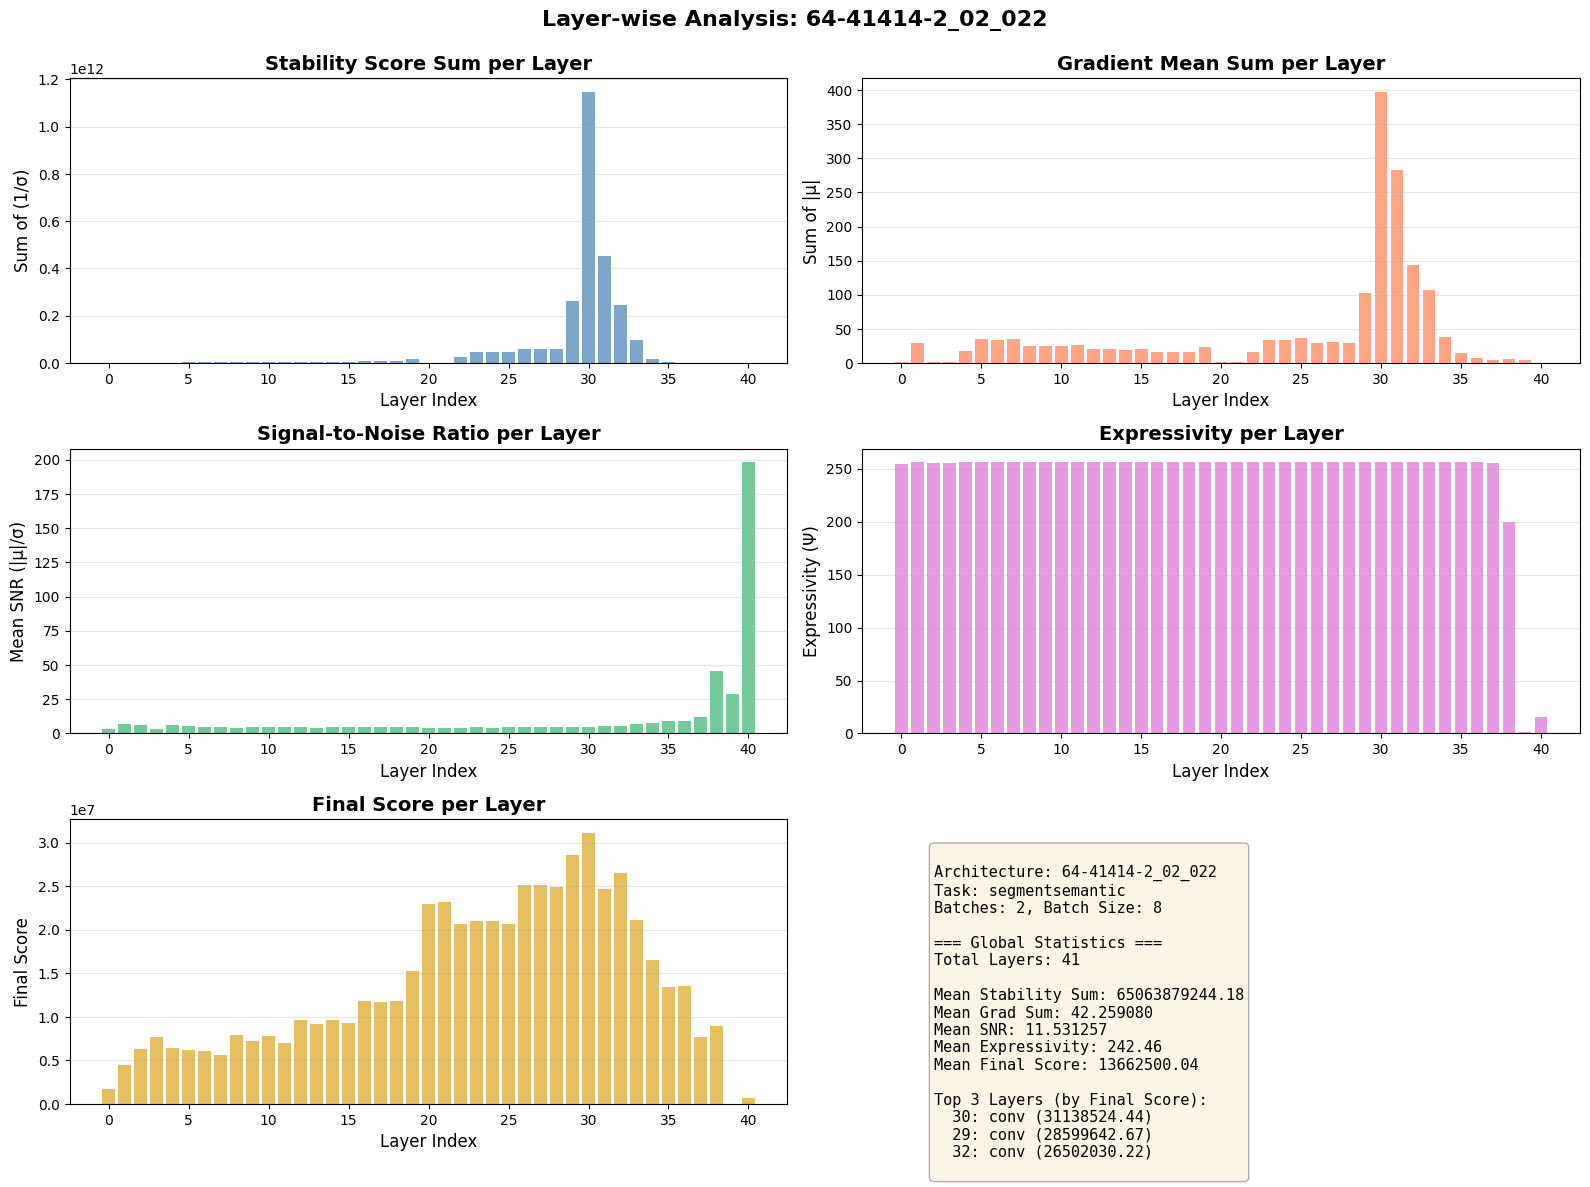


分析完成！


In [2]:
# ========== 第 9 部分：参数配置（在这里修改！）==========
CONFIG = {
    # ========== 搜索空间和任务配置 ==========
    'search_space': 'micro',  # 选择: "micro" 或 "macro"
    'task': 'segmentsemantic',  # 选择: "autoencoder", "segmentsemantic", "class_scene", 等
    
    # ========== 架构选择配置 ==========
    'rank': 1,  # 排名（第几名或倒数第几名）
    'from_top': False,  # True: 从最好开始（第1名=最好）, False: 从最差开始（第1名=最差）
    
    # ========== 数据配置 ==========
    'batch_size': 8,  # Batch 大小
    'num_batches': 2,  # 使用多少个 batch
    
    # ========== 设备配置 ==========
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# ========== 运行分析 ==========
if __name__ == "__main__":
    print("\n当前配置:")
    print("-" * 80)
    for key, value in CONFIG.items():
        print(f"  {key}: {value}")
    print("-" * 80)
    
    layer_stats, arch_str, gt_score = main(CONFIG)